In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import median_abs_deviation
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sys import stdout
from scipy.stats import f
from sklearn.model_selection import cross_val_predict
from scipy.signal import savgol_filter
import obspy
from obspy.signal.detrend import polynomial
import seaborn as sns 

In [19]:
# Load and prepare data
df_avg = pd.read_pickle('/root/autodl-tmp/vertigo/data/1_EDA_data.pkl')
X = df_avg.iloc[:, -112:]  # Last 112 columns are spectral data
Y_brix = df_avg['Brix'].values    # Target: Brix 
Y_TA = df_avg['TA'].values        # Target: TA
Y_firmness = df_avg['Firmness (kg)'].values  # Target: Firmness


X2 = savgol_filter(X, 15, polyorder = 2, deriv=2)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_brix, test_size=0.2, random_state=42, shuffle=True
)

# Standardize spectral data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



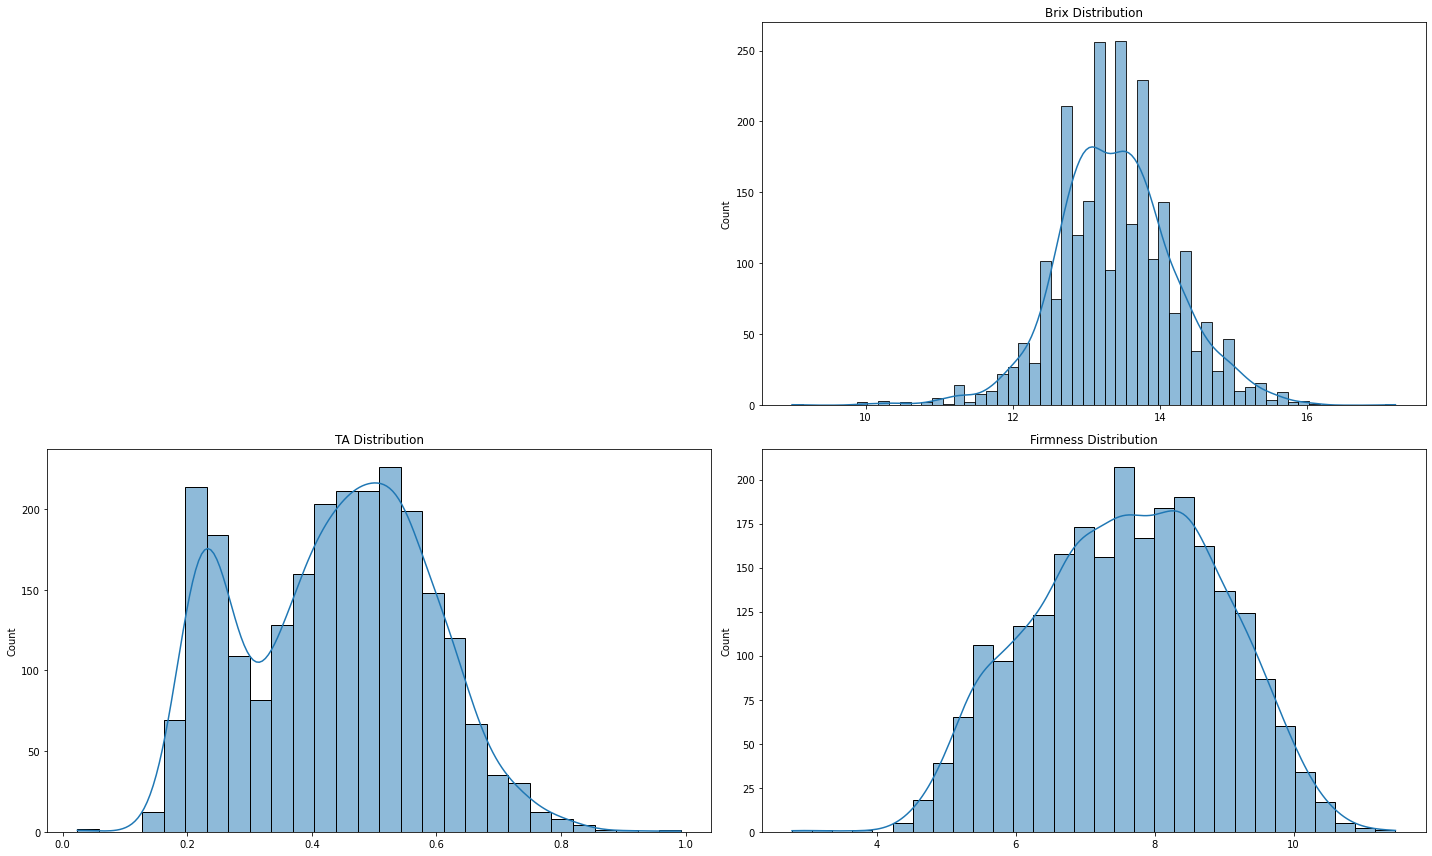

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats

## 1. Visual Inspection of Data Distributions
def plot_distributions(X, Y_brix, Y_TA, Y_firmness):
    plt.figure(figsize=(20, 12))
    
    # # Plot spectral data distribution (sample some wavelengths)
    # plt.subplot(2, 2, 1)
    # sample_cols = np.random.choice(X.columns, 10, replace=False)
    # for col in sample_cols:
    #     sns.kdeplot(X[col], alpha=0.5)
    # plt.title('Distribution of Sample Spectral Bands')
    # plt.xlabel('Intensity')
    
    # Plot target distributions
    plt.subplot(2, 2, 2)
    sns.histplot(Y_brix, kde=True)
    plt.title('Brix Distribution')
    
    plt.subplot(2, 2, 3)
    sns.histplot(Y_TA, kde=True)
    plt.title('TA Distribution')
    
    plt.subplot(2, 2, 4)
    sns.histplot(Y_firmness, kde=True)
    plt.title('Firmness Distribution')
    
    plt.tight_layout()
    plt.show()

plot_distributions(X, Y_brix, Y_TA, Y_firmness)

In [63]:
## 2. Statistical Outlier Detection
def detect_statistical_outliers(data, threshold=3):
    """
    Detect outliers using z-score method
    Returns boolean mask of outliers (True = outlier)
    """
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

# Detect outliers in spectral data 
from sklearn.decomposition import PCA

# Reduce spectral data to 5 principal components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Detect outliers in PCA space for spectral data
spectral_outliers_stats = detect_statistical_outliers(X_pca).any(axis=1)

# Detect outliers in target variables only use statistical method
brix_outliers = detect_statistical_outliers(Y_brix.reshape(-1, 1))
ta_outliers = detect_statistical_outliers(Y_TA.reshape(-1, 1))
firmness_outliers = detect_statistical_outliers(Y_firmness.reshape(-1, 1))

print(f"Statistical outliers detected - Spectral: {spectral_outliers_stats.sum()}, Brix: {brix_outliers.sum()}, TA: {ta_outliers.sum()}, Firmness: {firmness_outliers.sum()}")


Statistical outliers detected - Spectral: 151, Brix: 15, TA: 2, Firmness: 2


In [64]:
def detect_ml_outliers(data, contamination=0.02):
    """
    Use Isolation Forest and LOF for robust outlier detection
    Returns consensus outliers from both methods
    """
    # Isolation Forest
    iso = IsolationForest(contamination=contamination, random_state=42)
    iso_pred = iso.fit_predict(data)
    
    # Local Outlier Factor
    lof = LocalOutlierFactor(contamination=contamination)
    lof_pred = lof.fit_predict(data)
    
    # Consensus voting (both methods must agree it's an outlier)
    return (iso_pred == -1) & (lof_pred == -1)

# Detect outliers in spectral data
spectral_outliers_ml = detect_ml_outliers(X_pca)

# Detect outliers in combined target space
targets = np.column_stack((Y_brix, Y_TA, Y_firmness))
target_outliers_ml = detect_ml_outliers(targets)

print(f"ML-based outliers detected - Spectral: {spectral_outliers_ml.sum()}, Targets: {target_outliers_ml.sum()}")

ML-based outliers detected - Spectral: 11, Targets: 22


In [65]:
## 4. Consensus Outlier Identification 

# Flatten 
brix_outliers = brix_outliers.flatten()
ta_outliers = ta_outliers.flatten()
firmness_outliers = firmness_outliers.flatten()

# Combine target outliers (OR operation)
target_outliers_stat_combined = brix_outliers | ta_outliers | firmness_outliers

# Combine statistical and ML approaches for spectral data (AND)
spectral_outliers_combined = spectral_outliers_stats & spectral_outliers_ml

# # Combine statistical and ML approaches for target data (AND)
target_outliers_combined = target_outliers_stat_combined & target_outliers_ml

# Final outliers: sample is outlier if EITHER spectral OR target is outlier
final_outliers = spectral_outliers_combined | target_outliers_combined  # Using ML target outliers

print(f"\nCombined target outliers: {target_outliers_combined.sum()}")
print(f"Combined spectral outliers: {spectral_outliers_combined.sum()}")
print(f"Final outlier count: {final_outliers.sum()} samples ({final_outliers.sum()/len(df_avg)*100:.2f}%)")



Combined target outliers: 10
Combined spectral outliers: 11
Final outlier count: 21 samples (0.86%)


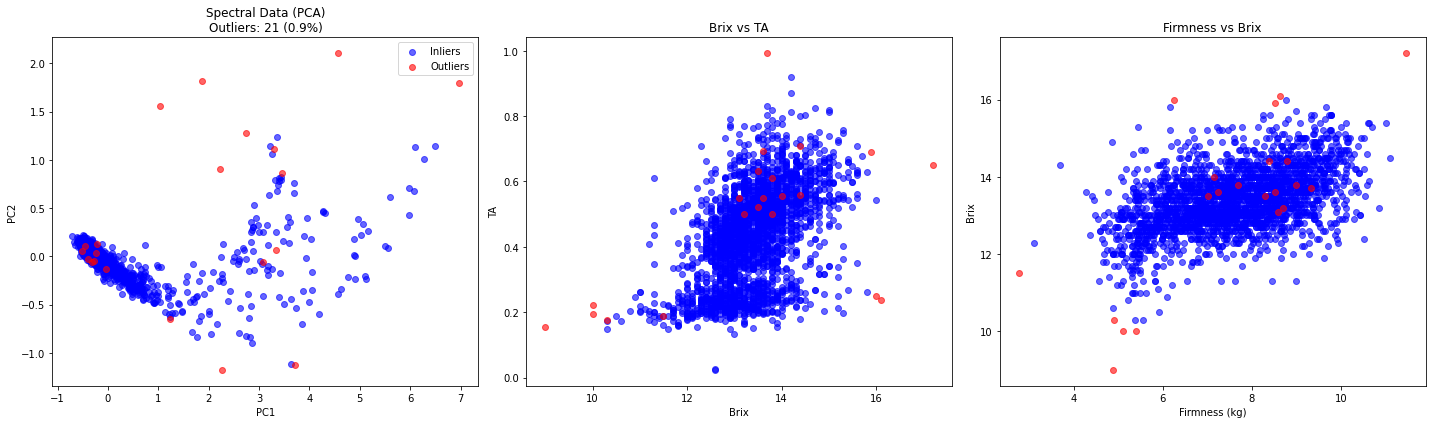

In [66]:
def plot_outliers_with_stats(X_pca, Y_brix, Y_TA, Y_firmness, outliers):
    plt.figure(figsize=(20, 6))
    
    # Plot PCA space
    plt.subplot(1, 3, 1)
    inliers = ~outliers
    plt.scatter(X_pca[inliers, 0], X_pca[inliers, 1], c='blue', alpha=0.6, label='Inliers')
    plt.scatter(X_pca[outliers, 0], X_pca[outliers, 1], c='red', alpha=0.6, label='Outliers')
    plt.title(f'Spectral Data (PCA)\nOutliers: {outliers.sum()} ({outliers.sum()/len(outliers)*100:.1f}%)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    
    # Plot Brix vs TA
    plt.subplot(1, 3, 2)
    plt.scatter(Y_brix[inliers], Y_TA[inliers], c='blue', alpha=0.6, label='Inliers')
    plt.scatter(Y_brix[outliers], Y_TA[outliers], c='red', alpha=0.6, label='Outliers')
    plt.title('Brix vs TA')
    plt.xlabel('Brix')
    plt.ylabel('TA')
    
    # Plot Firmness vs Brix
    plt.subplot(1, 3, 3)
    plt.scatter(Y_firmness[inliers], Y_brix[inliers], c='blue', alpha=0.6, label='Inliers')
    plt.scatter(Y_firmness[outliers], Y_brix[outliers], c='red', alpha=0.6, label='Outliers')
    plt.title('Firmness vs Brix')
    plt.xlabel('Firmness (kg)')
    plt.ylabel('Brix')
    
    plt.tight_layout()
    plt.show()

plot_outliers_with_stats(X_pca, Y_brix, Y_TA, Y_firmness, final_outliers)

In [67]:
## 6. Outlier Handling Options
def handle_outliers(df_avg, X, Y_brix, Y_TA, Y_firmness, outliers, method='remove'):
    """
    Handle outliers using specified method:
    - 'remove': delete outlier samples
    - 'winsorize': cap extreme values
    - 'impute': replace with median
    """
    if method == 'remove':
        # Remove outliers from all data
        df_clean = df_avg[~outliers].copy()
        X_clean = X[~outliers]
        Y_brix_clean = Y_brix[~outliers]
        Y_TA_clean = Y_TA[~outliers]
        Y_firmness_clean = Y_firmness[~outliers]
        
    elif method == 'winsorize':
        # Winsorize spectral data
        from scipy.stats.mstats import winsorize
        X_clean = X.apply(lambda x: winsorize(x, limits=[0.05, 0.05]))
        
        # Winsorize targets
        Y_brix_clean = winsorize(Y_brix, limits=[0.05, 0.05])
        Y_TA_clean = winsorize(Y_TA, limits=[0.05, 0.05])
        Y_firmness_clean = winsorize(Y_firmness, limits=[0.05, 0.05])
        
        df_clean = df_avg.copy()
        df_clean['Brix'] = Y_brix_clean
        df_clean['TA'] = Y_TA_clean
        df_clean['Firmness (kg)'] = Y_firmness_clean
        
    elif method == 'impute':
        # Impute with median for spectral data
        from sklearn.impute import SimpleImputer
        imp = SimpleImputer(strategy='median')
        X_clean = pd.DataFrame(imp.fit_transform(X), columns=X.columns)
        
        # Impute targets with median
        Y_brix_clean = np.where(outliers, np.median(Y_brix), Y_brix)
        Y_TA_clean = np.where(outliers, np.median(Y_TA), Y_TA)
        Y_firmness_clean = np.where(outliers, np.median(Y_firmness), Y_firmness)
        
        df_clean = df_avg.copy()
        df_clean['Brix'] = Y_brix_clean
        df_clean['TA'] = Y_TA_clean
        df_clean['Firmness (kg)'] = Y_firmness_clean
    
    print(f"Data shape after {method} handling: {X_clean.shape}")
    return df_clean, X_clean, Y_brix_clean, Y_TA_clean, Y_firmness_clean

# Example usage - remove outliers (recommended for spectral data)
df_clean, X_clean, Y_brix_clean, Y_TA_clean, Y_firmness_clean = handle_outliers(
    df_avg, X, Y_brix, Y_TA, Y_firmness, final_outliers, method='remove'
)


Data shape after remove handling: (2416, 112)


In [68]:
df_clean.to_pickle('/root/autodl-tmp/vertigo/data/2_clean_data.pkl')

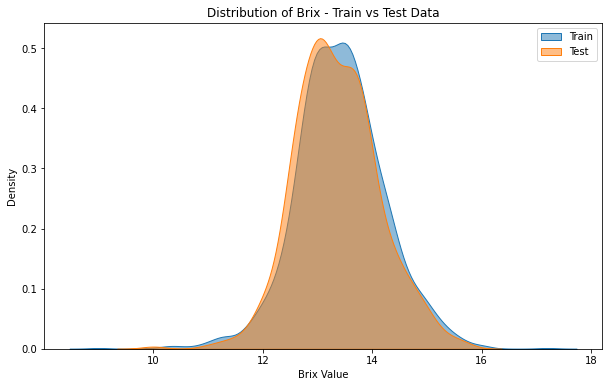

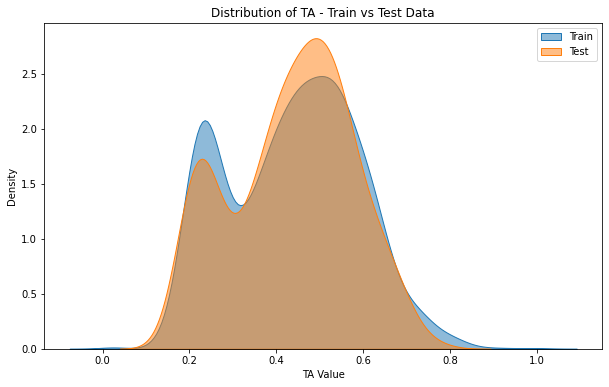

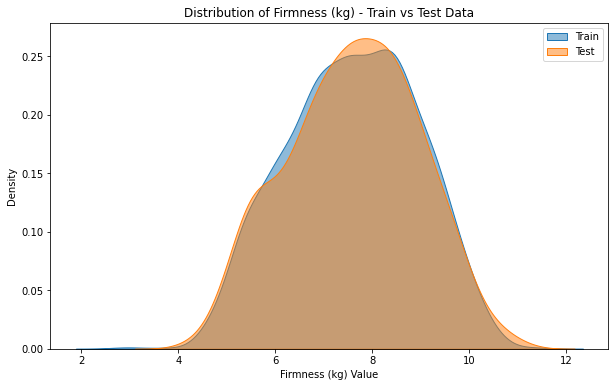

In [70]:
# Create train-test splits for all targets
X_train_brix, X_test_brix, Y_train_brix, Y_test_brix = train_test_split(
    X_scaled, Y_brix, test_size=0.2, random_state=42, shuffle=True
)

X_train_TA, X_test_TA, Y_train_TA, Y_test_TA = train_test_split(
    X_scaled, Y_TA, test_size=0.2, random_state=42, shuffle=True
)

X_train_firmness, X_test_firmness, Y_train_firmness, Y_test_firmness = train_test_split(
    X_scaled, Y_firmness, test_size=0.2, random_state=42, shuffle=True
)

# Plot distributions for each target
targets = [
    ('Brix', Y_train_brix, Y_test_brix),
    ('TA', Y_train_TA, Y_test_TA),
    ('Firmness (kg)', Y_train_firmness, Y_test_firmness)
]

for target_name, y_train, y_test in targets:
    plt.figure(figsize=(10, 6))
    plt.title(f'Distribution of {target_name} - Train vs Test Data')
    sns.kdeplot(y_train, label='Train', fill=True, alpha=0.5)
    sns.kdeplot(y_test, label='Test', fill=True, alpha=0.5)
    plt.legend()
    plt.xlabel(f'{target_name} Value')
    plt.ylabel('Density')
    plt.show()

In [20]:
## Define the Huber distance (source DeepChemometrics)
def huber(y_true, y_pred, delta=1.0):
    y_true = y_true.reshape(-1,1)
    y_pred = y_pred.reshape(-1,1)
    return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

## Create a huber loss scorer for cross_val_score()
huber_score=make_scorer(huber)


## Function to help find the best number of components of the PLS based on 10 CV Huber Loss
def pls_data_optimization(X, Y, plot_components=False):
    """
    This function finds the optimal number of PLS components (up to 40) that best models the data
    based on huber loss and 10 CV
    X - The training data X
    Y - The training data Y
    plot_components - Plot the model's optimization and optimized model
    """
    #Run PLS including a variable number of components, up to 40,  and calculate mean of 10 CV huber loss
    cv_huber=[]
    component = np.arange(1, 40)
    for i in component:
        pls = PLSRegression(n_components=i)
        cv_score=cross_val_score(pls, X, Y, cv=KFold(10, shuffle = True),\
                        n_jobs=-1, scoring=huber_score)
        cv_huber.append(np.mean(cv_score))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum
    cv_hubermin = np.argmin(cv_huber)
    print("Suggested number of components based in Mean of 10 CV huber loss: ", cv_hubermin+1)
    print('Minimum found in Mean of 10 CV huber loss: {}'.format(np.min(cv_huber)))
    stdout.write("\n")
 
    # Define PLS with suggested number of components and fit train data
    pls = PLSRegression(n_components=cv_hubermin+1)
    pls.fit(X, Y)
    
    # Get predictions for calibration(train) and validation(test) sets
    Y_pred = pls.predict(X) 
    
    # Calculate and print scores for validation set
    R2_p = r2_score(Y, Y_pred)
    mse_p = mean_squared_error(Y, Y_pred)
    hub_p = huber(Y, Y_pred)
    sep = np.std(Y_pred-Y)
    rmse_p = np.sqrt(mse_p)
    
    print('\nError metrics for test set:')
    print('R2: %5.3f'  % R2_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
 
    # Plot regression and PLS LV search
    rangey = max(Y) - min(Y)
    rangex = max(Y_pred) - min(Y_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        ax1=plt.subplot(1,2,1)
        ax1.plot(component, np.array(cv_huber), '-v', color = 'blue', mfc='blue')
        ax1.plot(component[cv_hubermin], np.array(cv_huber)[cv_hubermin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel('Mean od 10 CV Huber loss')
        plt.title('# PLS components')
        plt.xlim(left=-1)

        z = np.polyfit(np.ravel(Y), np.ravel(Y_pred), 1)        
        ax2 = plt.subplot(1,2,2, aspect=1)
        ax2.scatter(Y,Y_pred,c='k',s=2)
        ax2.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y, Y, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.1*rangey, 'R$^{2}=$ %5.3f'  % R2_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.2*rangey, 'Huber loss: %5.3f' % hub_p)
        plt.show()    
    return 



## Function that computes the PLS model and metrics for a train - test set pair and a given number of LV
def pls_prediction2(X_calib, Y_calib, X_valid, Y_valid, components, plot_components=False):
    """
    Very similar to the two previous functions but without the optimization part
    This function is simply used to compute the PLS model and the error metrics.
    NOTE: For the final error metrics we should use the benchmark() because we need
    take into consideration the unscaled version of the data.
    """
    i=components
    pls = PLSRegression(n_components=i)
    # Fit
    pls.fit(X_calib, Y_calib)
    # Prediction
    Y_pred = pls.predict(X_valid)
         
    # Calculate and print scores
    score_p = r2_score(Y_valid, Y_pred)
    mse_p = mean_squared_error(Y_valid, Y_pred)
    hub_p = huber(Y_valid, Y_pred)
    rmse_p = np.sqrt(mse_p)
    y_err = Y_valid-Y_pred
    sep = np.std(Y_pred-Y_valid)
  
    print('R2: %5.3f'  % score_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)

 
    # Plot regression and figures of merit
    rangey = max(Y_valid) - min(Y_valid)
    rangex = max(Y_pred) - min(Y_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        z = np.polyfit(np.ravel(Y_valid), np.ravel(Y_pred), 1)
        ax2 = plt.subplot(aspect=1)
#         ax2.fill_between(Y_cal, y_est-y_err, y np.ravel(z[1]+z[0]*np.arange(150,240))-2.5*sep, facecolor='red', alpha=0.5)
        ax2.scatter(Y_valid,Y_pred,c='r',s=2)
        ax2.plot(Y_valid, z[1]+z[0]*Y_valid, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y_valid, Y_valid, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.2*rangey, 'Huber loss: %5.3f' % hub_p)

        plt.show() 
        
    return Y_pred, pls


## Function to benchmark model error metrics (adapted from DeepChemometrics)
## This function computes error between the predictions made by a "model" and the original data.
def benchmark(x_train,y_train,x_test, y_test, model):
    """
    Think of this as:
    model(x_train, y_train) -> trained_model
    predicted_y = trained_model(x_test)
    error_metric = compute_error_between(y_test, predicted_y)
    """

    ######
    ## CONVERT Y values to initial scale before computing error metrics 
    y_train_true=yscaler.inverse_transform(y_train)
    y_test_true=yscaler.inverse_transform(y_test)
    y_train_pred=yscaler.inverse_transform(model.predict(x_train)).reshape(y_train_true.shape)
    y_test_pred=yscaler.inverse_transform(model.predict(x_test)).reshape(y_test_true.shape)
    
    ## Compute error metrics
    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    R2_train= r2_score(y_train_true, y_train_pred)
    R2_test= r2_score(y_test_true, y_test_pred)
    hub_train = huber(y_train_true, y_train_pred)
    hub_test = huber(y_test_true, y_test_pred)
    
    ## Print stuff
    print('\n\n*********** Benchmark results *********** \n')
    print("R2  \t(Train/Test) = \t{:.3f}\t/  {:.3f}".format(R2_train, R2_test))    
    print("RMSE  \t(Train/Test) = \t{:.3f} \t/  {:.3f}".format(rmse_train, rmse_test))
    print ("Huber \t(Train/Test) = \t{:.3f}\t/  {:.3f}".format(hub_train, hub_test))

100% completed
Suggested number of components based in Mean of 10 CV huber loss:  21
Minimum found in Mean of 10 CV huber loss: 0.19886028063728328


Error metrics for test set:
R2: 0.251
Root Mean Squared Error (RMSE): 0.696
Huber loss (huber): 0.188
Standard Error Prediction (SEP): 0.696


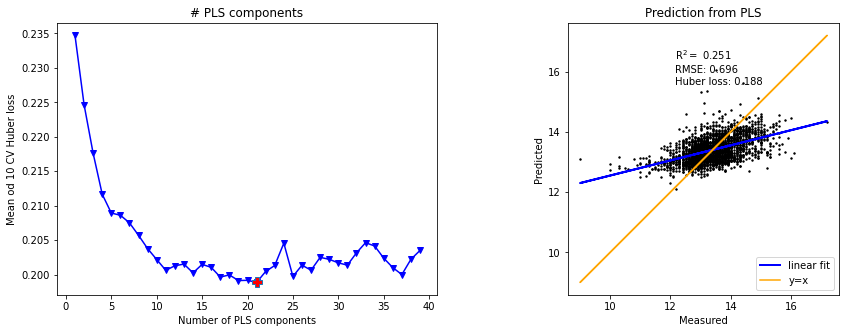

In [ ]:
pls_data_optimization(X_scaled, Y_brix, plot_components=True)

Optimal PLS model applyed to full dataset 
R2: 0.251
Root Mean Squared Error (RMSE): 0.696
Huber loss (huber): 0.188
Standard Error Prediction (SEP): 0.696


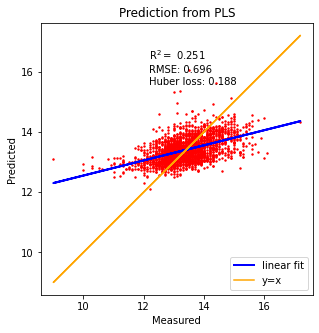

In [56]:
print('Optimal PLS model applyed to full dataset ')    
y_pred_brix, _= pls_prediction2(X_scaled, Y_brix, X_scaled, Y_brix, components=21,plot_components=True)  

Standard Deviation of error = 0.4438749075151946


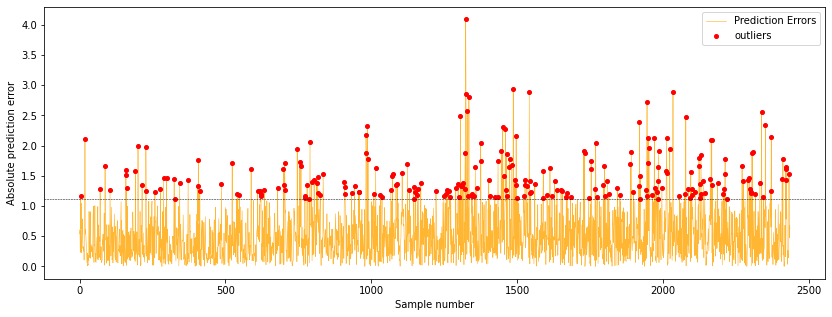

In [57]:
pred_error_brix=np.abs(Y_brix-np.ravel(y_pred_brix))
pred_error_brix_std=pred_error_brix.std()
print('Standard Deviation of error = {}'.format(pred_error_brix_std))
ind_brix=np.ravel(np.where(pred_error_brix>=2.5*pred_error_brix_std)).reshape(-1,1)

plt.figure(figsize=(14,5))
plt.plot(pred_error_brix, c='orange',label='Prediction Errors', alpha=0.8, lw=0.6)
plt.plot(ind_brix, pred_error_brix[pred_error_brix>=2.5*pred_error_brix_std],'ro',label='outliers', markersize=4)
plt.axhline(2.5*pred_error_brix_std,c='k',ls='--',lw=0.5)


plt.xlabel('Sample number')
plt.ylabel('Absolute prediction error')
plt.legend()
plt.show()

In [58]:
# print(np.ravel(ind_brix))
print('Number of outliers: {}'.format(len(ind_brix)))

Number of outliers: 242


PLS model for full clean dataset 

R2: 0.367
Root Mean Squared Error (RMSE): 0.507
Huber loss (huber): 0.114
Standard Error Prediction (SEP): 0.507


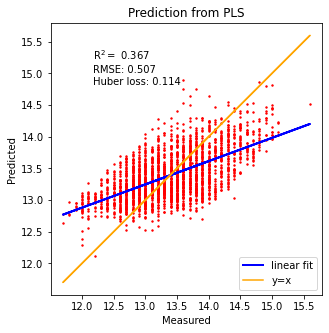

In [59]:
## Recompute PLS for the full clean datasets

print('PLS model for full clean dataset \n')
X_brix_clean=np.delete(X_scaled,ind_brix,axis=0)
Y_brix_clean=np.delete(Y_brix,ind_brix,axis=0)
y_pred_brix, _=pls_prediction2(X_brix_clean,Y_brix_clean, X_brix_clean,Y_brix_clean,components=21, plot_components=True) 

* Y_TA 

100% completed
Suggested number of components based in Mean of 10 CV huber loss:  38
Minimum found in Mean of 10 CV huber loss: 0.004343521736327575


Error metrics for test set:
R2: 0.651
Root Mean Squared Error (RMSE): 0.088
Huber loss (huber): 0.004
Standard Error Prediction (SEP): 0.088


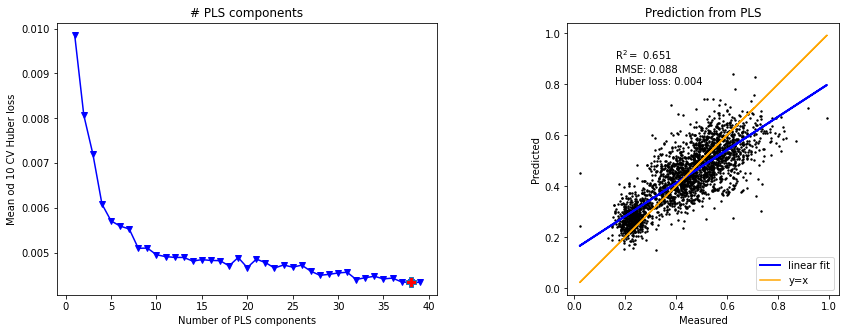

In [38]:
pls_data_optimization(X_scaled, Y_TA, plot_components=True)

Optimal PLS model applyed to full dataset 
R2: 0.651
Root Mean Squared Error (RMSE): 0.088
Huber loss (huber): 0.004
Standard Error Prediction (SEP): 0.088


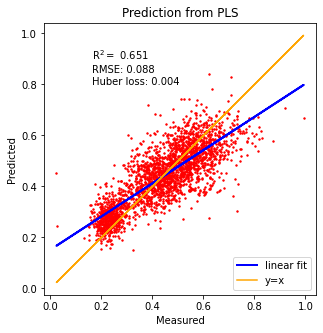

In [62]:
print('Optimal PLS model applyed to full dataset ')    
y_pred_TA, _= pls_prediction2(X_scaled, Y_TA, X_scaled, Y_TA, components=38,plot_components=True)  

Standard Deviation of error = 0.05551114104013414


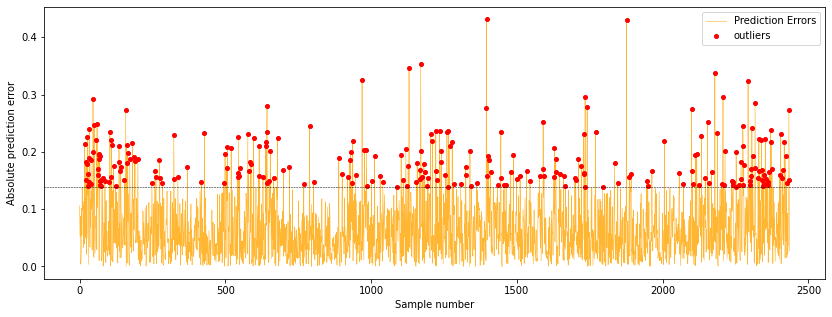

Number of outliers: 264


In [63]:
pred_error_TA=np.abs(Y_TA-np.ravel(y_pred_TA))
pred_error_TA_std=pred_error_TA.std()
print('Standard Deviation of error = {}'.format(pred_error_TA_std))
ind_TA=np.ravel(np.where(pred_error_TA>=2.5*pred_error_TA_std)).reshape(-1,1)

plt.figure(figsize=(14,5))
plt.plot(pred_error_TA, c='orange',label='Prediction Errors', alpha=0.8, lw=0.6)
plt.plot(ind_TA, pred_error_TA[pred_error_TA>=2.5*pred_error_TA_std],'ro',label='outliers', markersize=4)
plt.axhline(2.5*pred_error_TA_std,c='k',ls='--',lw=0.5)


plt.xlabel('Sample number')
plt.ylabel('Absolute prediction error')
plt.legend()
plt.show()

# print(np.ravel(ind_TA))
print('Number of outliers: {}'.format(len(ind_TA)))

PLS model for full clean dataset 

R2: 0.798
Root Mean Squared Error (RMSE): 0.063
Huber loss (huber): 0.002
Standard Error Prediction (SEP): 0.063


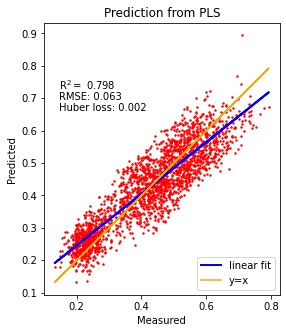

In [64]:
## Recompute PLS for the full clean datasets

print('PLS model for full clean dataset \n')
X_TA_clean=np.delete(X_scaled,ind_TA,axis=0)
Y_TA_clean=np.delete(Y_TA,ind_TA,axis=0)
y_pred_TA, _=pls_prediction2(X_TA_clean,Y_TA_clean, X_TA_clean,Y_TA_clean,components=38, plot_components=True) 

* Y_firmness

100% completed
Suggested number of components based in Mean of 10 CV huber loss:  37
Minimum found in Mean of 10 CV huber loss: 0.294525412083882


Error metrics for test set:
R2: 0.599
Root Mean Squared Error (RMSE): 0.853
Huber loss (huber): 0.272
Standard Error Prediction (SEP): 0.853


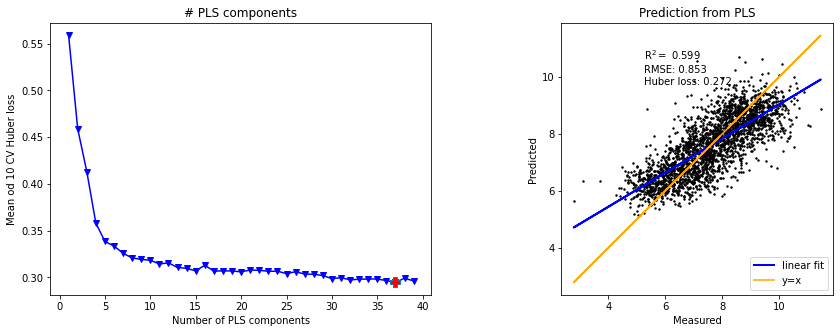

In [44]:
pls_data_optimization(X_scaled, Y_firmness, plot_components=True)

Optimal PLS model applyed to full dataset 
R2: 0.599
Root Mean Squared Error (RMSE): 0.853
Huber loss (huber): 0.272
Standard Error Prediction (SEP): 0.853


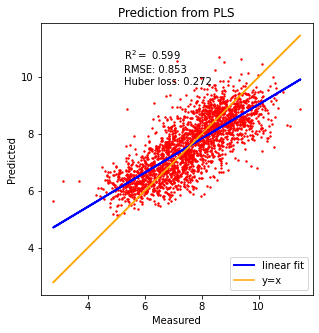

In [65]:
print('Optimal PLS model applyed to full dataset ')    
y_pred_firmness, _= pls_prediction2(X_scaled, Y_firmness, X_scaled, Y_firmness, components=37,plot_components=True)  

Standard Deviation of error = 0.5186742715378473


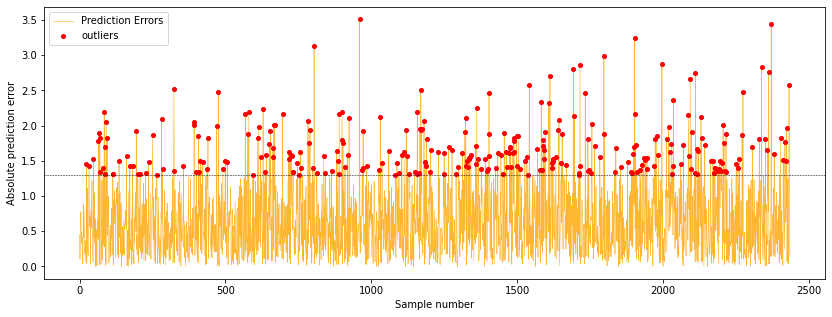

Number of outliers: 291


In [66]:
pred_error_firmness=np.abs(Y_firmness-np.ravel(y_pred_firmness))
pred_error_firmness_std=pred_error_firmness.std()
print('Standard Deviation of error = {}'.format(pred_error_firmness_std))
ind_firmness=np.ravel(np.where(pred_error_firmness>=2.5*pred_error_firmness_std)).reshape(-1,1)

plt.figure(figsize=(14,5))
plt.plot(pred_error_firmness, c='orange',label='Prediction Errors', alpha=0.8, lw=0.6)
plt.plot(ind_firmness, pred_error_firmness[pred_error_firmness>=2.5*pred_error_firmness_std],'ro',label='outliers', markersize=4)
plt.axhline(2.5*pred_error_firmness_std,c='k',ls='--',lw=0.5)


plt.xlabel('Sample number')
plt.ylabel('Absolute prediction error')
plt.legend()
plt.show()


print('Number of outliers: {}'.format(len(ind_firmness)))

PLS model for full clean dataset 

R2: 0.748
Root Mean Squared Error (RMSE): 0.627
Huber loss (huber): 0.168
Standard Error Prediction (SEP): 0.627


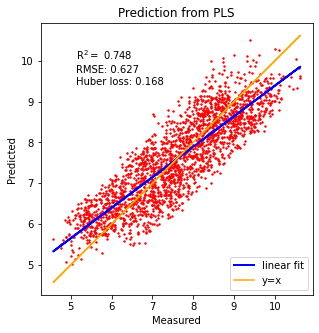

In [67]:
## Recompute PLS for the full clean datasets

print('PLS model for full clean dataset \n')
X_firmness_clean=np.delete(X_scaled,ind_firmness,axis=0)
Y_firmness_clean=np.delete(Y_firmness,ind_firmness,axis=0)
y_pred_firmness, _=pls_prediction2(X_firmness_clean,Y_firmness_clean, X_firmness_clean,Y_firmness_clean,components=37, plot_components=True) 

In [68]:
# Find common indices between the three arrays
common_indices = np.intersect1d(np.intersect1d(ind_firmness, ind_brix), ind_TA)

# Print the results
print(f"Common indices between Brix, TA, and Firmness: {common_indices}")
print(f"Number of common indices: {len(common_indices)}")

Common indices between Brix, TA, and Firmness: [  70   87  161 1031 1158 1170 1324 1325 1362 1403 1434 1499 1590 1892
 1945 2099 2112 2188 2207 2210 2339 2352 2372 2433]
Number of common indices: 24


In [70]:
# Remove the outliers from the dataset and save the clean dataset as a pickle file
df_avg_clean = df_avg.drop(index=np.ravel(common_indices))
print(df_avg_clean)
df_avg_clean.to_pickle('/root/autodl-tmp/vertigo/data/2_outlier_removal_pls.pkl')

     UniqueFruitID   TestDate  Experiment Cultivar  Fruit nr      Size  \
0        1_Cult1_1 2024-01-18           1    Cult1         1  3.503926   
1       1_Cult1_10 2024-01-18           1    Cult1        10  3.425187   
2      1_Cult1_100 2024-01-18           1    Cult1       100  3.562981   
3       1_Cult1_11 2024-01-18           1    Cult1        11  3.208652   
4       1_Cult1_12 2024-01-18           1    Cult1        12  2.834637   
...            ...        ...         ...      ...       ...       ...   
2431    5_Cult2_94 2024-03-20           5    Cult2        94  3.228337   
2432    5_Cult2_95 2024-03-20           5    Cult2        95  3.385817   
2434    5_Cult2_97 2024-03-20           5    Cult2        97  2.677157   
2435    5_Cult2_98 2024-03-20           5    Cult2        98  2.854322   
2436    5_Cult2_99 2024-03-20           5    Cult2        99  2.834637   

      Weight  Brix      TA  Firmness (kg)  ...  11.75_GHz_imag  12.0_GHz_imag  \
0        303  14.0  0.7073    

In [228]:
## Define the Huber distance (source DeepChemometrics)
def huber(y_true, y_pred, delta=1.0):
    y_true = y_true.reshape(-1,1)
    y_pred = y_pred.reshape(-1,1)
    return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

## Create a huber loss scorer for cross_val_score()
huber_score=make_scorer(huber)


def optimise_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        # y_cv = cross_val_predict(pls, X, y, cv=KFold(10, shuffle=True))
        # mse.append(mean_squared_error(y, y_cv))

        y_cv=cross_val_score(pls, X, y, cv=KFold(10, shuffle = True), scoring=huber_score)
        mse.append(np.mean(y_cv))


        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    optimal_comp = msemin+1
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    # Calculate Huber loss for calibration and cross validation
    huber_c = huber(y, y_c)
    huber_cv = huber(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    print('Huber calib: %5.3f' % huber_c)
    print('Huber CV: %5.3f' % huber_cv)
 
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
 
        plt.show()
 

    return optimal_comp

100% completed
Suggested number of components:  39



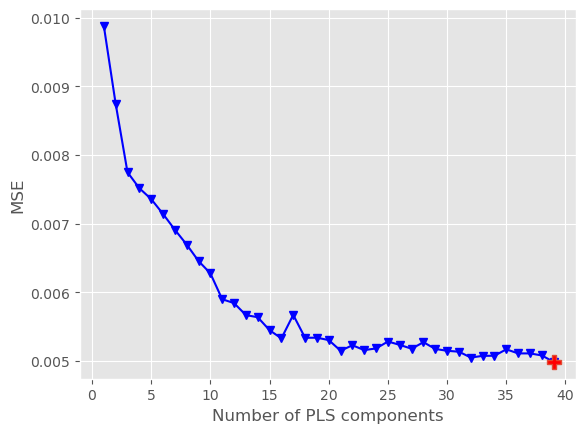

R2 calib: 0.623
R2 CV: 0.172
MSE calib: 0.008
MSE CV: 0.018
Huber calib: 0.004
Huber CV: 0.009


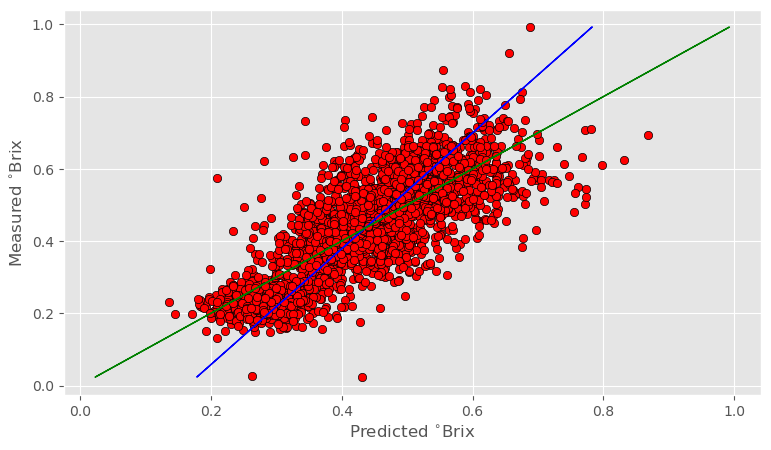

In [229]:
ncomp = optimise_pls_cv(X2, Y_TA, 40, plot_components=True)

Method 1:

In [223]:
pls = PLSRegression(n_components=ncomp)
pls.fit(X2, Y_brix)

# Get PLS scores (T) and loadings (P)
T = pls.x_scores_
P = pls.x_loadings_

# Calculate Q-residuals (unmodeled variance)
Err = X2 - np.dot(T, P.T)
Q = np.sum(Err**2, axis=1)

# Calculate Hotelling's T-squared (within-model extremeness)
Tsq = np.sum((T / np.std(T, axis=0))**2, axis=1)

In [224]:
conf = 0.99  # 97.5% confidence

# T-squared threshold (F-distribution)
df1 = ncomp
df2 = X2.shape[0] - ncomp
Tsq_conf = f.ppf(conf, df1, df2) * (df1 * (X2.shape[0]-1)) / (X2.shape[0]-df1)

# Q-residuals threshold (empirical 95th percentile)
Q_conf = np.percentile(Q, 95)

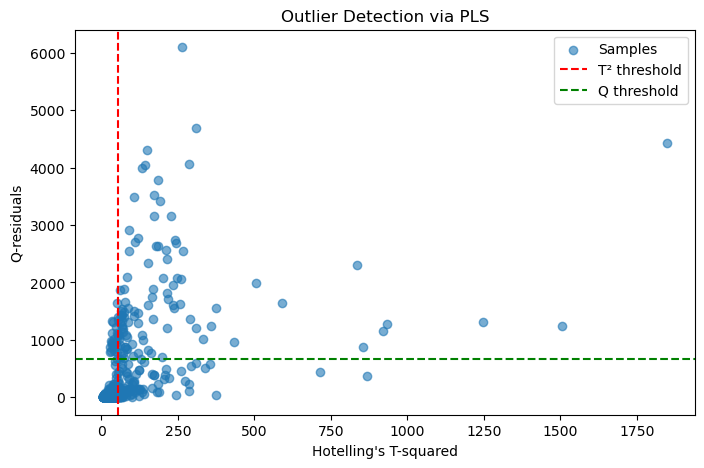

In [225]:
plt.figure(figsize=(8, 5))
plt.scatter(Tsq, Q, alpha=0.6, label='Samples')
plt.axvline(Tsq_conf, color='r', linestyle='--', label='T² threshold')
plt.axhline(Q_conf, color='g', linestyle='--', label='Q threshold')
plt.xlabel("Hotelling's T-squared")
plt.ylabel('Q-residuals')
plt.title('Outlier Detection via PLS')
plt.legend()
plt.show()

In [226]:
# Print R2 and RMSE for the model
y_pred = pls.predict(X2)
rmse = np.sqrt(mean_squared_error(Y_brix, y_pred))
r2 = r2_score(Y_brix, y_pred)
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Identify outliers (either Q or T² exceeds threshold)
outliers = np.where((Q > Q_conf) | (Tsq > Tsq_conf))[0]
print(f"Detected {len(outliers)} outliers.")

# Remove outliers
X_clean = np.delete(X2, outliers, axis=0)
y_clean = np.delete(Y_brix, outliers, axis=0)

# Validate the model after outlier removal
pls_clean = PLSRegression(n_components=ncomp)
y_pred_clean = pls_clean.fit(X_clean, y_clean).predict(X_clean)
rmse = np.sqrt(mean_squared_error(y_clean, y_pred_clean))
r2 = r2_score(y_clean, y_pred_clean)
print(f"R² after outlier removal: {r2:.4f}")
print(f"RMSE after outlier removal: {rmse:.4f}")

R²: 0.2551
RMSE: 0.6936
Detected 214 outliers.
R² after outlier removal: 0.4106
RMSE after outlier removal: 0.6148


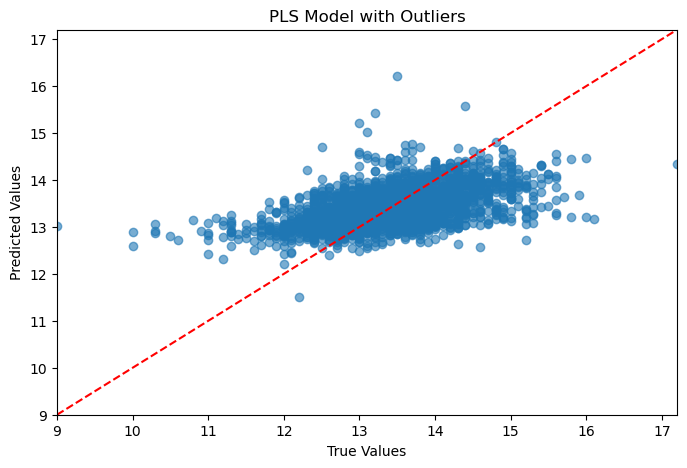

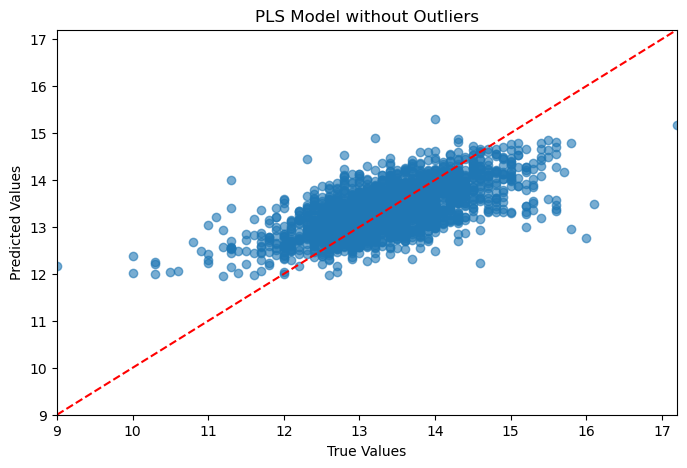

In [227]:
# compare the PLS model with the original data and the cleaned data
def plot_comparison(y_true, y_pred, title):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.xlim(y_true.min(), y_true.max())
    plt.ylim(y_true.min(), y_true.max())
    plt.show()
plot_comparison(Y_brix, y_pred, 'PLS Model with Outliers')
plot_comparison(y_clean, y_pred_clean, 'PLS Model without Outliers')


In [170]:
# Get outlier indices
outlier_indices_1 = np.where((Q > Q_conf) | (Tsq > Tsq_conf))[0]
# Get outlier data "UniqueFruitID"
outlier_data_1 = df_avg.iloc[outlier_indices_1]
# print UniqueFruitID for outliers
print("Outlier UniqueFruitIDs:")
for unique_id in outlier_data_1['UniqueFruitID']:
    print(unique_id)


Outlier UniqueFruitIDs:
1_Cult1_2
1_Cult1_6
2_Cult1_29
2_Cult1_61
2_Cult1_79
2_Cult1_94
2_Cult2_171
2_Cult2_187
2_Cult2_194
3_Cult1_121
3_Cult1_13
4_Cult1_1
4_Cult1_37
4_Cult3_102
4_Cult3_119
5_Cult1_1
5_Cult1_10
5_Cult1_100
5_Cult1_101
5_Cult1_103
5_Cult1_104
5_Cult1_106
5_Cult1_107
5_Cult1_108
5_Cult1_109
5_Cult1_11
5_Cult1_110
5_Cult1_111
5_Cult1_112
5_Cult1_113
5_Cult1_114
5_Cult1_117
5_Cult1_118
5_Cult1_12
5_Cult1_120
5_Cult1_123
5_Cult1_124
5_Cult1_125
5_Cult1_128
5_Cult1_129
5_Cult1_13
5_Cult1_130
5_Cult1_133
5_Cult1_136
5_Cult1_139
5_Cult1_14
5_Cult1_141
5_Cult1_142
5_Cult1_146
5_Cult1_147
5_Cult1_149
5_Cult1_15
5_Cult1_151
5_Cult1_152
5_Cult1_153
5_Cult1_154
5_Cult1_155
5_Cult1_156
5_Cult1_158
5_Cult1_159
5_Cult1_16
5_Cult1_160
5_Cult1_161
5_Cult1_162
5_Cult1_164
5_Cult1_165
5_Cult1_166
5_Cult1_167
5_Cult1_168
5_Cult1_169
5_Cult1_17
5_Cult1_170
5_Cult1_171
5_Cult1_172
5_Cult1_173
5_Cult1_174
5_Cult1_175
5_Cult1_176
5_Cult1_177
5_Cult1_18
5_Cult1_181
5_Cult1_182
5_Cult1_183
5_C